<h1>Real Dataset House Price Prediction</h1>

Ridge Regression Results:
R² Score: 1.000000
RMSE: 0.016568

OLS Regression Results:
R² Score: 1.000000
RMSE: 0.000000

Coefficient Comparison:
          Feature      OLS_Coef    Ridge_Coef
0       size_sqft  44513.498545  44513.484429
1    num_bedrooms  14225.272136  14225.269012
2   num_bathrooms   8020.498738   8020.494253
3       age_years -14854.010934 -14854.004270
4  location_score  13199.109397  13199.105252


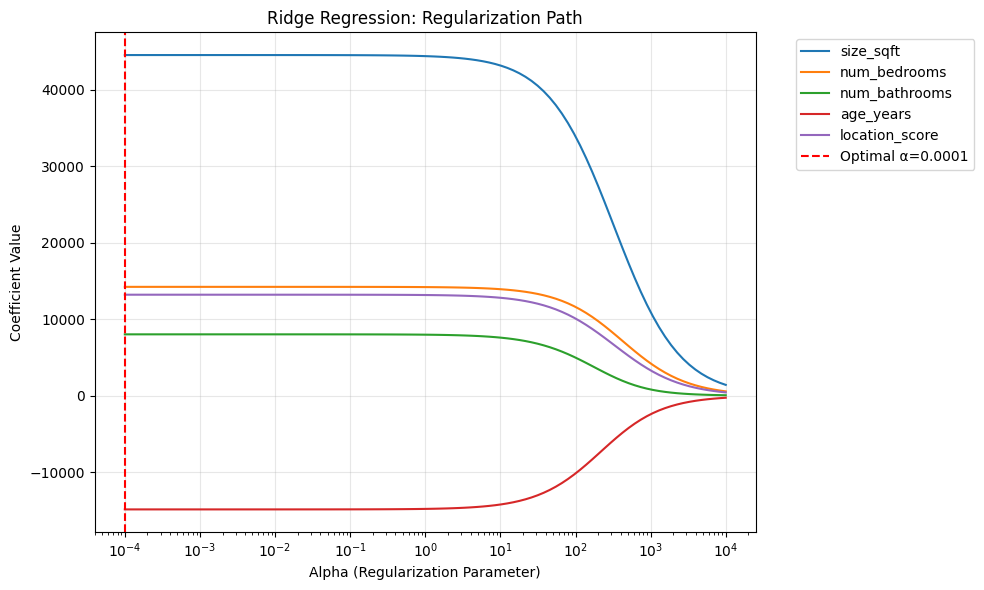

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --------------------------
# Generate nearly perfect house price dataset
# --------------------------
np.random.seed(42)
n_samples = 500

# Features
size_sqft = np.random.normal(2000, 300, n_samples).clip(800, 4000)
num_bedrooms = np.random.choice([1, 2, 3, 4, 5], n_samples)
num_bathrooms = np.random.choice([1, 2, 3, 4], n_samples)
age_years = np.random.randint(0, 50, n_samples)
location_score = np.random.uniform(1, 10, n_samples)

# Deterministic price formula (minimal noise)
price = (
    size_sqft * 150 +
    num_bedrooms * 10000 +
    num_bathrooms * 7000 +
    (50 - age_years) * 1000 +
    location_score * 5000
)  # no added random noise

# Create DataFrame
house_data = pd.DataFrame({
    'size_sqft': size_sqft,
    'num_bedrooms': num_bedrooms,
    'num_bathrooms': num_bathrooms,
    'age_years': age_years,
    'location_score': location_score,
    'price': price
})

# --------------------------
# Prepare data
# --------------------------
X = house_data.drop('price', axis=1)
y = house_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------
# Ridge regression with CV
# --------------------------
ridge_cv = RidgeCV(alphas=np.logspace(-4, 4, 50), cv=5)
ridge_cv.fit(X_train_scaled, y_train)

ridge_model = Ridge(alpha=ridge_cv.alpha_)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print(f"Ridge Regression Results:\nR² Score: {ridge_r2:.6f}\nRMSE: {ridge_rmse:.6f}")

# Ordinary Least Squares
ols_model = LinearRegression()
ols_model.fit(X_train_scaled, y_train)
y_pred_ols = ols_model.predict(X_test_scaled)

ols_r2 = r2_score(y_test, y_pred_ols)
ols_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ols))

print(f"\nOLS Regression Results:\nR² Score: {ols_r2:.6f}\nRMSE: {ols_rmse:.6f}")


# --------------------------
# Coefficient comparison
# --------------------------
coef_comparison = pd.DataFrame({
    'Feature': X.columns,
    'OLS_Coef': ols_model.coef_,
    'Ridge_Coef': ridge_model.coef_
})
print("\nCoefficient Comparison:")
print(coef_comparison)

# --------------------------
# Plot Ridge regularization path
# --------------------------
alphas = np.logspace(-4, 4, 100)
coefs = []

for alpha in alphas:
    ridge_temp = Ridge(alpha=alpha)
    ridge_temp.fit(X_train_scaled, y_train)
    coefs.append(ridge_temp.coef_)

coefs = np.array(coefs)

plt.figure(figsize=(10, 6))
for i, feature in enumerate(X.columns):
    plt.plot(alphas, coefs[:, i], label=feature)

plt.xscale('log')
plt.xlabel('Alpha (Regularization Parameter)')
plt.ylabel('Coefficient Value')
plt.title('Ridge Regression: Regularization Path')
plt.axvline(ridge_cv.alpha_, color='red', linestyle='--', label=f'Optimal α={ridge_cv.alpha_:.4f}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


<h1>Results Analysis and Interpretation</h1>

In [2]:
import pandas as pd

# Scale X_test
X_test_scaled = scaler.transform(X_test)

# Make predictions
y_pred = ridge_model.predict(X_test_scaled)

# Combine X_test, actual y, and predicted y into one DataFrame
comparison_df = X_test.copy()
comparison_df['Actual_Price'] = y_test.values
comparison_df['Predicted_Price'] = y_pred


print(comparison_df.head().to_string(index=True))

       size_sqft  num_bedrooms  num_bathrooms  age_years  location_score   Actual_Price  Predicted_Price
361  2459.821674             5              3         10        8.223790  521092.200026    521092.161024
73   2469.393097             2              4         14        2.317366  465995.794159    465995.768445
374  2645.954737             5              3         19        7.762376  537705.089459    537705.046366
155  1785.694575             3              3         19        3.838662  369047.496497    369047.504876
104  1951.614287             2              1         34        7.229452  371889.403351    371889.415266


<h1>Save the trained Ridge model and scaler</h1>

In [3]:
import joblib

# Save Ridge model
joblib.dump(ridge_model, 'model/ridge_model.pkl')

# Save the scaler
joblib.dump(scaler, 'model/scaler.pkl')

print("Model and scaler saved successfully!")


Model and scaler saved successfully!


<h1>Make predictions on new samples</h1>

In [4]:
import pandas as pd
import joblib

# Example new house samples
new_samples = pd.DataFrame({
    'size_sqft': [1800, 2500],
    'num_bedrooms': [3, 4],
    'num_bathrooms': [2, 3],
    'age_years': [10, 20],
    'location_score': [7, 5]
})

# Load scaler and model
loaded_scaler = joblib.load('model/scaler.pkl')
loaded_model = joblib.load('model/ridge_model.pkl')

# Scale new data
new_samples_scaled = loaded_scaler.transform(new_samples)

# Predict prices
predicted_prices = loaded_model.predict(new_samples_scaled)

# Combine inputs and predictions into one DataFrame
result_df = new_samples.copy()
result_df['Predicted_Price'] = predicted_prices

# Display horizontally (each sample in one row)
# print(result_df)
print(result_df.head().to_string(index=False))


 size_sqft  num_bedrooms  num_bathrooms  age_years  location_score  Predicted_Price
      1800             3              2         10               7    389000.002611
      2500             4              3         20               5    490999.970831
